In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import os
import gc
from sklearn.metrics import f1_score, confusion_matrix ,classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from keras_preprocessing.image import load_img, img_to_array, array_to_img ,ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D , GlobalAveragePooling2D
from keras.optimizers import Adam , RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler , EarlyStopping ,TensorBoard
from keras import optimizers 
from keras.models import load_model

from keras.applications.xception import Xception
#from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input

from livelossplot import PlotLossesKeras

2024-06-20 06:29:46.274091: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-20 06:29:47.228949: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(2019)

In [3]:
train_dir = 'Meat Freshness.v1-new-dataset.multiclass/train'
valid_dir = 'Meat Freshness.v1-new-dataset.multiclass/valid'
train_labels = 'Meat Freshness.v1-new-dataset.multiclass/train/_classes.csv'
valid_labels = 'Meat Freshness.v1-new-dataset.multiclass/valid/_classes.csv'

train_df = pd.read_csv(train_labels)
valid_df = pd.read_csv(valid_labels)

train_df['filename'] = train_df['filename'].apply(lambda x: os.path.join(train_dir, x))
valid_df['filename'] = valid_df['filename'].apply(lambda x: os.path.join(valid_dir, x))
train_df.columns = train_df.columns.str.strip()
valid_df.columns = valid_df.columns.str.strip()

In [10]:
valid_df.iloc[0][0]

'Meat Freshness.v1-new-dataset.multiclass/valid/HALF-FRESH-8-_JPG.rf.5bf1ec7ab3a5bca8b3a01bbd330ff733.jpg'

In [19]:

fresh_count = valid_df['Fresh'].sum()
half_fresh_count = valid_df['Half-Fresh'].sum()
spoiled_count = valid_df['Spoiled'].sum()

# Printing the results
print("Total number of Fresh:", fresh_count)
print("Total number of Half-Fresh:", half_fresh_count)
print("Total number of Spoiled:", spoiled_count)



fresh_count_train = train_df['Fresh'].sum()
half_fresh_count_train = train_df['Half-Fresh'].sum()
spoiled_count_train = train_df['Spoiled'].sum()

# Printing the results
print("Total number of Fresh:", fresh_count_train)
print("Total number of Half-Fresh:", half_fresh_count_train)
print("Total number of Spoiled:", spoiled_count_train)


print("Total Fresh", fresh_count + fresh_count_train)
print("Total Half Fresh", half_fresh_count + half_fresh_count_train)
print("Total Spoiled", spoiled_count + spoiled_count_train)

Total number of Fresh: 178
Total number of Half-Fresh: 159
Total number of Spoiled: 114
Total number of Fresh: 675
Total number of Half-Fresh: 630
Total number of Spoiled: 510
Total Fresh 853
Total Half Fresh 789
Total Spoiled 624


In [16]:
from PIL import Image
import numpy as np

# Load the image
image = Image.open('Meat Freshness.v1-new-dataset.multiclass/valid/HALF-FRESH-8-_JPG.rf.5bf1ec7ab3a5bca8b3a01bbd330ff733.jpg')

# Convert the image to RGB (if not already in that format)
# image = image.convert('RGB')

# Convert image to a numpy array
pixel_values = np.array(image)

# Now, pixel_values is a three-dimensional numpy array (height, width, channels)
# where channels are RGB (red, green, blue).
print(pixel_values.shape)
print(pixel_values)


(416, 416, 3)
[[[142 154 134]
  [136 148 128]
  [127 140 122]
  ...
  [121 155 128]
  [109 144 114]
  [102 137 107]]

 [[146 158 138]
  [140 152 132]
  [131 144 126]
  ...
  [118 152 125]
  [116 151 121]
  [108 143 113]]

 [[148 161 143]
  [144 157 139]
  [137 150 133]
  ...
  [112 145 118]
  [121 154 125]
  [113 146 117]]

 ...

 [[ 50  23  14]
  [ 50  23  14]
  [ 50  23  14]
  ...
  [159 118 116]
  [163 122 120]
  [166 125 123]]

 [[ 49  22  13]
  [ 49  22  13]
  [ 49  22  13]
  ...
  [161 120 118]
  [165 124 122]
  [167 126 124]]

 [[ 49  22  13]
  [ 49  22  13]
  [ 49  22  13]
  ...
  [166 125 123]
  [163 122 120]
  [159 118 116]]]


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 1815 validated image filenames.
Found 451 validated image filenames.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the Xception model, excluding the top layer
base_model = Xception(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer with the number of classes
predictions = Dense(3, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First, we only train the top layers (which were randomly initialized)
# Freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the new data for a few epochs
history_initial = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=20
)

# At this point, the top layers are well trained and we can start fine-tuning
# the convolutional layers from Xception. We will freeze the bottom N layers
# and train the remaining top layers.

# Let's unfreeze some layers from Xception and train further
for layer in model.layers[:126]:
    layer.trainable = False
for layer in model.layers[126:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=20
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(valid_generator)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

2024-06-20 06:30:07.057011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20387 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


Epoch 1/20


2024-06-20 06:30:13.643686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2024-06-20 06:30:14.710489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-20 06:30:14.904614: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5601e5088cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-20 06:30:14.904678: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-06-20 06:30:14.962727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-20 06:30:15.347568: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 [==============================] - 28s 389ms/step - loss: 0.6398 - accuracy: 0.7336 - val_loss: 0.4574 - val_accuracy: 0.8013
Epoch 2/20
56/56 [==============================] - 20s 363ms/step - loss: 0.3037 - accuracy: 0.8676 - val_loss: 0.1949 - val_accuracy: 0.9442
Epoch 3/20
56/56 [==============================] - 20s 363ms/step - loss: 0.2692 - accuracy: 0.8884 - val_loss: 0.2927 - val_accuracy: 0.8504
Epoch 4/20
56/56 [==============================] - 20s 365ms/step - loss: 0.1838 - accuracy: 0.9277 - val_loss: 0.1778 - val_accuracy: 0.9420
Epoch 5/20
56/56 [==============================] - 20s 365ms/step - loss: 0.1991 - accuracy: 0.9220 - val_loss: 0.1990 - val_accuracy: 0.9152
Epoch 6/20
56/56 [==============================] - 20s 364ms/step - loss: 0.1634 - accuracy: 0.9361 - val_loss: 0.1605 - val_accuracy: 0.9353
Epoch 7/20
56/56 [==============================] - 20s 362ms/step - loss: 0.1379 - accuracy: 0.9428 - val_loss: 0.1062 - val_accuracy: 0.9665
Epoch 8/20

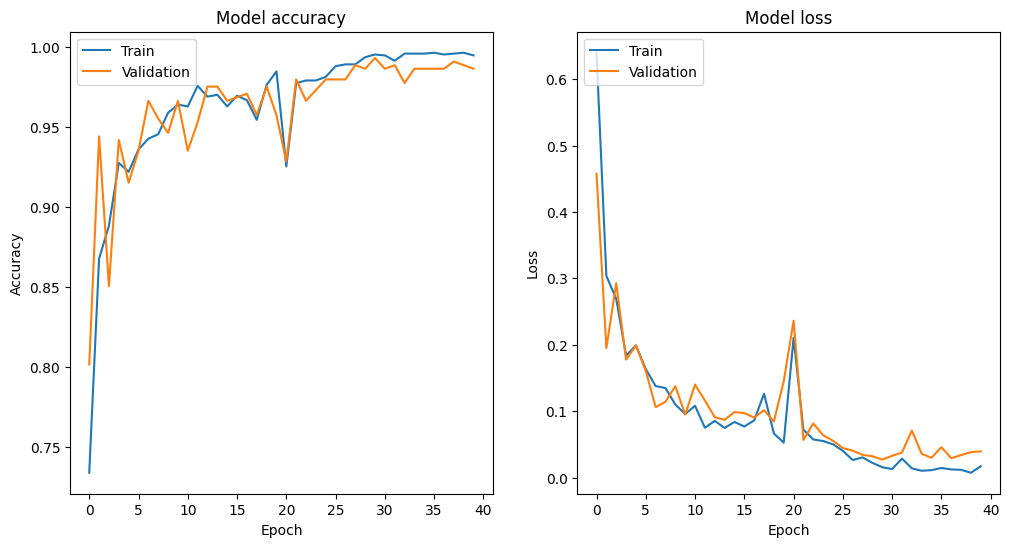

451/451 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

       Fresh       0.98      0.99      0.99       178
  Half-Fresh       0.98      0.98      0.98       159
     Spoiled       1.00      0.99      1.00       114

    accuracy                           0.99       451
   macro avg       0.99      0.99      0.99       451
weighted avg       0.99      0.99      0.99       451



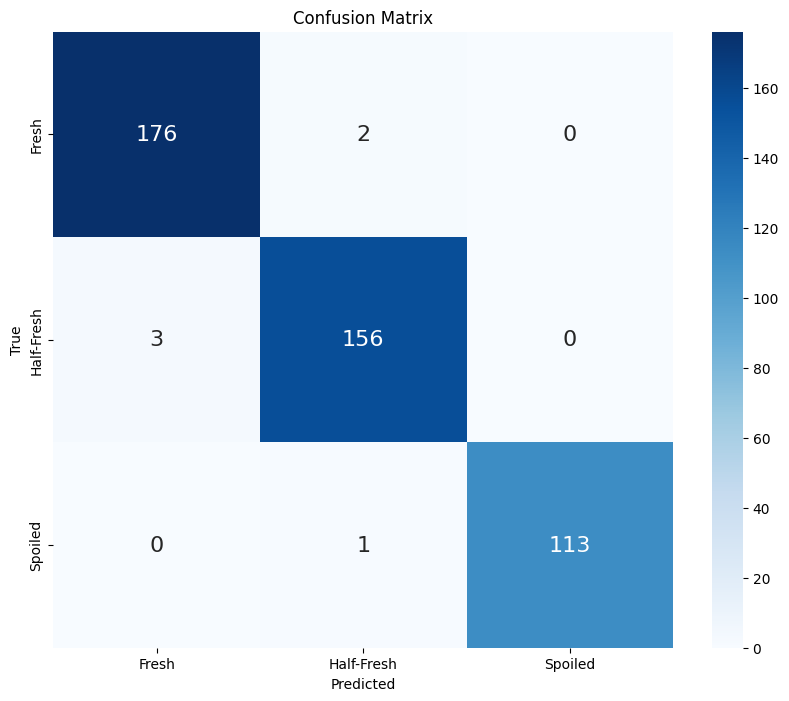

In [23]:
history = {
    'loss': history_initial.history['loss'] + history_finetune.history['loss'],
    'val_loss': history_initial.history['val_loss'] + history_finetune.history['val_loss'],
    'accuracy': history_initial.history['accuracy'] + history_finetune.history['accuracy'],
    'val_accuracy': history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy']
}

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

valid_generator.reset()
predictions = model.predict(valid_generator, steps=len(valid_generator.filenames), verbose=1)
#model.predict_generator(valid_generator)

# Convert predictions to one-hot encoded format
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(valid_generator.labels, axis=1)

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=['Fresh', 'Half-Fresh','Spoiled'])
print(report)


conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fresh', 'Half-Fresh','Spoiled'], yticklabels=['Fresh', 'Half-Fresh','Spoiled'],annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 36ms/step
0
Fresh


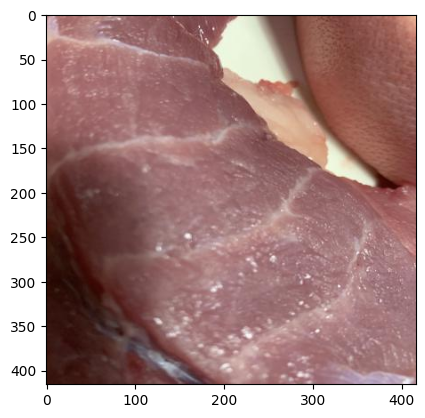

In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np

class_labels = ['Fresh', 'Half-Fresh', 'Spoiled']
target_size = (224, 224)

def load_and_preprocess_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale pixel values
    return img_array

def predict_single_image(model, image_path, target_size, class_labels):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path, target_size)
    img = image.load_img(image_path)
    plt.imshow(img)
    
    # Make a prediction
    predictions = model.predict(img_array)
    
    # Convert predictions to class probabilities
    predicted_class = np.argmax(predictions, axis=1)
    print(predicted_class[0])
    predicted_label = class_labels[predicted_class[0]]
    print(predicted_label)


image_path = 'Meat Freshness.v1-new-dataset.multiclass/valid/FRESH-10-_JPG.rf.b39881c9ff5786aac7f0b9f6f76deb58.jpg'

predict_single_image(model, image_path, target_size, class_labels)
